# Long Distance Ranging of Europa by REASON
### Michelle Park
Follows the Overleaf document -- goal is to constrain the distance and Doppler ranging measurements of Europa Clipper by REASON. From what range can we detect a returned signal from Europa? Must also account for assumptions in surface roughness / radar cross section that we can play with below.

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import scienceplots

## Link Budget
Using the radar link budget equation, the power received is:
\begin{equation}
    P_r = \frac{P_tG_t}{4\pi d^2}\frac{\sigma A_e}{4\pi d^2}\,,
\end{equation}
with $A_e$ being the effective area of the antenna and $d$ being the distance of Clipper from Europa's surface.

With G = 6dB, $A_e=G\lambda^2 / 4\pi \approx 8$ m$^2$ for the VHF and $A_e\approx352 $m$^2$ for the HF.

In [84]:
def radar_equation(Pt, Gt, d, rcs, wavelength):
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    return ((Pt*Gt)/(4*np.pi*d**4))*((rcs*Ae)/(4*np.pi)) # return power received

Radar cross section of Europa (R=1560 km) is
\begin{equation}
\sigma = \pi R^2\left\lvert\frac{n_1-n_2}{n_1+n_2}\right\rvert^2 = 2.8\times10^{10}\,,
\end{equation}
using $n_1=1$ and $n_2=1.13$ for ice.

In [85]:
# Radar cross section of Europa
R = 1560e3 #m
n1 = 1
n2 = 1.13 # ice
rcs_split = np.pi*R**2*np.abs((n1-n2)/(n1+n2))**2 
print("RCS: {:e}".format(rcs_split))

RCS: 2.847912e+10


We can compare our result to the *radar potential* first, which assumes d = 400 km and that Europa is a perfectly conducting sphere (use $\pi R^2$ as the RCS).

We'll need to use $d^3$ in the denominator instead of $d^4$ since 400 km is close to Europa. Refer to "Geometric Power Fall-Off in Radar Sounding" by Haynes + Schroeder.

In [86]:
# radar equation with smooth rcs
smooth_rcs = np.pi*R**2 # power in = power out

# radar potential ~ 63 dB VHF & ~65 dB HF
Pr_smooth_hf = radar_equation(10, 10**(6/10), 400000, smooth_rcs, (2.998e8)/(9e6)) # for HF
SNR_smooth_hf = 10*np.log10(Pr_smooth_hf/(3.52*10**-9))# divide by the N_galactic power

Pr_smooth_vhf = radar_equation(10, 10**(6/10), 400000, smooth_rcs, (2.998e8)/(60e6)) # for VHF
SNR_smooth_vhf = 10*np.log10(Pr_smooth_vhf/(3.52*10**-9))
print("Radar potential (HF): {:.2f} dB".format(SNR_smooth_hf))
print("Radar potential (VHF): {:.2f} dB".format(SNR_smooth_vhf))

Radar potential (HF): 8.76 dB
Radar potential (VHF): -7.72 dB


ALTERNATIVELY, we can use the mean roughness of different regions of Europa, linked [here](https://www.sciencedirect.com/science/article/abs/pii/S0019103519301526). 
90% of Europa's surface are:
- Ridged plains ($\sigma_0 = 0.58 m$, $H = 0.65$ for $\lambda < 1 km$, $H = 0.28$ for $\lambda > 1 km$) 
- Chaos (matrix, plains) ($\sigma_0 = 1.31 m$, $H = 0.69$ for $\lambda < 1 km$, $H = 0.36$ for $\lambda > 1 km$)

The remainder are:
- Craters ($\sigma_0 = 0.60 m$, $H = 0.69$ for $\lambda < 1 km$, $H = 0.52$ for $\lambda > 1 km$) 
- Double ridges / bands ($\sigma_0 = 0.66 m$, $H = 0.43$ for $\lambda < 1 km$, $H = 0.24$ for $\lambda > 1 km$).

We describe the roughness per wavelength: $S/\lambda = \sigma_0 \lambda^H$. For both VHF and HF, the wavelength is less than 1 km for the Hurst exponent. 

Using the plot in figure 4 of Peters et al. (linked [here](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2004JB003222)), we can determine the roughness surface loss from roughness per wavelength. 

We calculate the RMS phase variation $g = 4 \pi S/\lambda$ to find the reflection reduction $\rho = \exp(-g^2)I_0^2(g^2/2)$ for $I_0$ being the zero-order modified Bessel function.

To find the radar cross section of Europa, we multiply the RCS of a perfect electric conductor sphere $\times$ Fresnel coefficient of ice $\times$ roughness surface loss from the surface characteristics above.

In [87]:
# find the average roughness surface loss
def roughness_surface_loss(wavelength):
    # roughness per wavelength for the 90% majority (ridged plains, chaos)
    majority_roughness = 0.58*wavelength**0.65 + 1.31*wavelength**0.69
    # roughness per wavelength for the remaining surface characteristics (craters, double ridges/bands)
    minority_roughness= 0.60*wavelength**0.69 + 0.66*wavelength**0.43
    
    # average roughness/wavelength of entire surface
    ave_roughness = (0.9*majority_roughness + 0.1*minority_roughness)/4

    # determine roughness surface loss from Peters et al. 
    g = 4*np.pi*ave_roughness/wavelength # rms phase variation
    rho = np.exp(-g**2)*(np.i0(g**2/2)**2)
    
    return 1-rho # in non-dB units

In [88]:
c = 2.998e8 # m/s
vhf_wavelength = c/(60e6) # m
hf_wavelength = c/(9e6) # m

rcs_vhf = rcs_split*roughness_surface_loss(vhf_wavelength)
rcs_hf = rcs_split*roughness_surface_loss(hf_wavelength)
print("RCS for VHF: {:e}".format(rcs_vhf))
print("RCS for HF: {:e}".format(rcs_hf))

RCS for VHF: 2.764642e+10
RCS for HF: 2.507809e+10


From smoothest to roughest: band/double ridge, ridged plains, craters, chaos terrain. We can compare with the RCS for pointing to the leading hemisphere of Europa, which is dominated by ridged plains.

In [89]:
def ridged_plains_roughness_surface_loss(wavelength):
    # roughness per wavelength for ridged plains
    ave_roughness = 0.58*wavelength**0.65 

    # determine roughness surface loss from Peters et al. 
    g = 4*np.pi*ave_roughness/wavelength # rms phase variation
    rho = np.exp(-g**2)*(np.i0(g**2/2)**2)
    
    return 1-rho # in non-dB units

In [90]:
rcs_vhf_rp = rcs_split*ridged_plains_roughness_surface_loss(vhf_wavelength)
rcs_hf_rp = rcs_split*ridged_plains_roughness_surface_loss(hf_wavelength)
print("#### Ridged plains only ####")
print("RCS for VHF: {:e}".format(rcs_vhf))
print("RCS for HF: {:e}".format(rcs_hf))
# Gives a slight improvement 

#### Ridged plains only ####
RCS for VHF: 2.764642e+10
RCS for HF: 2.507809e+10


Assume: 
- REASON 60 MHz VHF antenna with 10 MHz bandwidth 
- REASON HF antenna with 9 MHz and 1 MHz bandwidth. 
- Speed (relative to Europa) is 4 km/s.
- REASON can emit 10 W into space with a maximum pulse duration of XX and a VHF antenna gain of 6 dB. 

For the lowest altitude (25 km), this leads to a VHF link budget of

In [91]:
# LINK BUDGET PARAMETERS
Pt_hf = 11.75
Pt_vhf = 5.5
Gt_hf = 10**(4/10) # 4 dB -> B
Gt_vhf = 10**(7.3/10) # 7.3 dB -> B
d = 25000 # altitude (m)
c = 2.998e8 # m/s
rcs = rcs_hf
vhf_wavelength = c/(60e6) # m
hf_wavelength = c/(9e6) # m

print("#### For lowest altitude (25 km) ####")
Pr_vhf = radar_equation(Pt_vhf, Gt_vhf, d, rcs, vhf_wavelength)
print(r'P_r of VHF = ' + str(Pr_vhf) + ' W/m^4')

Pr_hf = radar_equation(Pt_hf, Gt_hf, d, rcs, hf_wavelength)
print(r'P_r of HF = ' + str(Pr_hf) + ' W/m^4')

#### For lowest altitude (25 km) ####
P_r of VHF = 1.2812335190719989e-07 W/m^4
P_r of HF = 2.6614661746292355e-06 W/m^4


### Noise + SNR
We can assume a galactic noise background if $N=10^{-17}$ W/MHz/m$^2$ and a detection threshold of 10 dB. However, there is intermittent and predictable radiation from Jupiter, which reaches a peak flux density of $N \approx 10^{-14} \mathrm{W/MHz/m^2}$ - this only affects the signal captured by HF. 

For the lowest altitude:

In [92]:
def max_range(Pt, Gt, rcs, wavelength, Plimit, pulse_compression_gain, N):
    Pr = (10**((Plimit-pulse_compression_gain)/10))*N # solve for required SNR
    
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    # Solve for the radar equation, but solve for d
    d = ((Pt*Gt*rcs*Ae)/(Pr*16*np.pi**2))**0.25
    
    return d

In [93]:
N_galactic = 10**-17 # W/MHz/m^2
N_jupiter = 10**-14 # W/MHz/m^2 # CONSIDER range of noise?

print("#### For lowest altitude (25 km) ####")
# HF - galactic noise vs. Jupiter noise
SNR_hf_galactic = Pr_hf / N_galactic
print("SNR of HF -- no Jupiter noise: {:.1f} dB".format(10*np.log10(SNR_hf_galactic)))
SNR_hf_jupiter = Pr_hf / N_jupiter
print("SNR of HF -- with Jupiter noise: {:.1f} dB".format(10*np.log10(SNR_hf_jupiter)))

SNR_vhf = Pr_vhf / N_galactic
print("SNR of VHF -- no Jupiter noise: {:.1f} dB".format(10*np.log10(SNR_vhf)))

max_d_HF_galactic = max_range(Pt_hf, Gt_hf, rcs_split, hf_wavelength, 10, 0, N_galactic)
max_d_HF_jupiter = max_range(Pt_hf, Gt_hf, rcs_split, hf_wavelength, 10, 0, N_jupiter)
max_d_VHF = max_range(Pt_vhf, Gt_vhf, rcs_split, vhf_wavelength, 10, 0, N_galactic)
 
# solve for the maximum pulse length
print("#### Maximum range -- maximized pulse length ####")
print("HF -- no Jupiter noise -- max. range: {:.0f} km".format(max_d_HF_galactic/1000))
#print("HF -- with Jupiter noise -- max. range: {:.0f} km".format(max_d_HF_jupiter/1000))
print("VHF -- no Jupiter noise -- max. range: {:.0f} km".format(max_d_VHF/1000))

#### For lowest altitude (25 km) ####
SNR of HF -- no Jupiter noise: 114.3 dB
SNR of HF -- with Jupiter noise: 84.3 dB
SNR of VHF -- no Jupiter noise: 101.1 dB
#### Maximum range -- maximized pulse length ####
HF -- no Jupiter noise -- max. range: 10424 km
VHF -- no Jupiter noise -- max. range: 4883 km


### Maximum Range
Now, we can test the upper limit for long distance ranging. The pulse length can vary $25 - 200 \mu s$ for VHF and $10 - 236 \mu s$ for HF. The bandwidth is 1 MHz for HF, 10 MHz for VHF. The pulse compression gain equals the ratio of the initial pulse length to the compressed pulse ($1/B_w$). From this, we can solve for the *maximum range*.

This problem becomes interesting if we can detect a signal at 40,000-50,000 km, which is the maximum nadir height for Clipper. 

Max. range @ longest pulse, ridged plains: 39577.490 km
Max. range @ longest pulse, icy sphere: 40856.040 km
Max. range @ 1 uncompressed pulse (HF): 10423.853 km
Max. range @ 1 uncompressed pulse (VHF): 4882.645 km


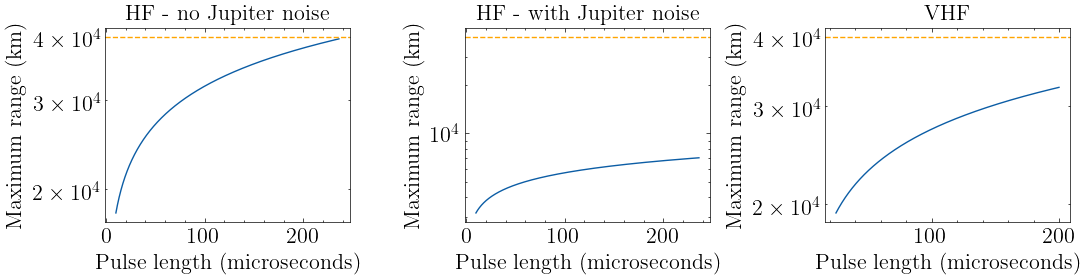

In [94]:
pulse_length_hf = np.linspace(10*10**-6, 236*10**-6, 10000, endpoint=True) # s
pulse_length_vhf = np.linspace(25*10**-6, 200*10**-6, 10000, endpoint=True) # s

pulse_compressed_hf = 1/(10**6) # 1/B_w
pulse_compressed_vhf = 1/(10*10**6) # 1/B_w

pulse_compression_gain_hf = 10*np.log10(pulse_length_hf/pulse_compressed_hf)
pulse_compression_gain_vhf = 10*np.log10(pulse_length_vhf/pulse_compressed_vhf)

# P_r must be at least 10 dB
Plimit = 10 #dB

max_d_HF_galactic = max_range(Pt_hf, Gt_hf, rcs, hf_wavelength, Plimit, pulse_compression_gain_hf, N_galactic)
max_d_HF_jupiter = max_range(Pt_hf, Gt_hf, rcs, hf_wavelength, Plimit, pulse_compression_gain_hf, N_jupiter)
max_d_VHF = max_range(Pt_vhf, Gt_vhf, rcs_vhf, vhf_wavelength, Plimit, pulse_compression_gain_vhf, N_galactic)

fig, ax = plt.subplots(1, 3, figsize=(11,3))

ax[0].plot(pulse_length_hf/10**-6, max_d_HF_galactic/1000)
ax[0].set_xlabel("Pulse length (microseconds)")
ax[0].set_ylabel("Maximum range (km)")
ax[0].set_title("HF - no Jupiter noise")

ax[1].plot(pulse_length_hf/10**-6, max_d_HF_jupiter/1000)
ax[1].set_xlabel("Pulse length (microseconds)")
ax[1].set_ylabel("Maximum range (km)")
ax[1].set_title("HF - with Jupiter noise")

ax[2].plot(pulse_length_vhf/10**-6, max_d_VHF/1000)
ax[2].set_xlabel("Pulse length (microseconds)")
ax[2].set_ylabel("Maximum range (km)")
ax[2].set_title("VHF")

# Label nadir height
ax[0].axhline(40000, ls='--', color='orange')
ax[1].axhline(40000, ls='--', color='orange')
ax[2].axhline(40000, ls='--', color='orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

#ax[0].set_ylim((1*10**3, 6*10**4))
#ax[1].set_ylim((1*10**3, 6*10**4))
#ax[2].set_ylim((1*10**3, 6*10**4))

plt.tight_layout()

### PRINT MAX RANGE @ longest pulse (compare RCS_hf_rp ridged plains vs. RCS_split icy sphere)
max_d_HF_rp = max_range(Pt_hf, Gt_hf, rcs_hf, hf_wavelength, Plimit, pulse_compression_gain_hf, N_galactic)
max_d_HF_icy = max_range(Pt_hf, Gt_hf, rcs_split, hf_wavelength, Plimit, pulse_compression_gain_hf, N_galactic)
print("Max. range @ longest pulse, ridged plains: {:.3f} km".format(max_d_HF_rp[-1]/1000))
print("Max. range @ longest pulse, icy sphere: {:.3f} km".format(max_d_HF_icy[-1]/1000))

### PRINT MAX RANGE @ 1 uncompressed pulse, icy, noise
# just to hit some power detection threshold based on radar equation
max_d_HF_simple = max_range(Pt_hf, Gt_hf, rcs_split, hf_wavelength, Plimit, 0, N_galactic)
max_d_VHF_simple = max_range(Pt_vhf, Gt_vhf, rcs_split, vhf_wavelength, Plimit, 0, N_galactic)
print("Max. range @ 1 uncompressed pulse (HF): {:.3f} km".format(max_d_HF_simple/1000))
print("Max. range @ 1 uncompressed pulse (VHF): {:.3f} km".format(max_d_VHF_simple/1000))


We can maximize the pulse length for both HF and VHF,  giving the following maximum ranges:

In [95]:
# solve for the maximum pulse length
print("#### Maximum range -- maximized pulse length ####")
print("HF -- no Jupiter noise -- pulse length: {:.0f} microseconds, max. range: {:.0f} km".format(pulse_length_hf[-1]/10**-6, max_d_HF_galactic[-1]/1000))
print("HF -- with Jupiter noise -- pulse length: {:.0f} microseconds, max. range: {:.0f} km".format(pulse_length_hf[-1]/10**-6, max_d_HF_jupiter[-1]/1000))
print("VHF -- no Jupiter noise -- pulse length: {:.0f} microseconds, max. range: {:.0f} km".format(pulse_length_vhf[-1]/10**-6, max_d_VHF[-1]/1000))

#### Maximum range -- maximized pulse length ####
HF -- no Jupiter noise -- pulse length: 236 microseconds, max. range: 39577 km
HF -- with Jupiter noise -- pulse length: 236 microseconds, max. range: 7038 km
VHF -- no Jupiter noise -- pulse length: 200 microseconds, max. range: 32411 km


Now we can plot surface roughness vs. maximum range for different values of surface roughness, ranging from the radar cross section of pure water/ice sphere to the estimate from calculating the roughness of various Europa regions.

In [96]:
# max out pulse length
pulse_length_hf = 236*10**-6 # s
pulse_length_vhf = 200*10**-6 # s
pulse_compressed_hf = 1/(10**6) # 1/B_w
pulse_compressed_vhf = 1/(10*10**6) # 1/B_w
pulse_compression_gain_hf = 10*np.log10(pulse_length_hf/pulse_compressed_hf)
pulse_compression_gain_vhf = 10*np.log10(pulse_length_vhf/pulse_compressed_vhf)

# P_r must be at least 10 dB
Plimit = 10 #dB

hf_bandwidth = 1e6 # Hz
hf_Ae = (Gt_hf*hf_wavelength**2)/(4*np.pi)
vhf_bandwidth = 10e6 # Hz
vhf_Ae = (Gt_vhf*vhf_wavelength**2)/(4*np.pi)

# TRY RCS RANGE
rcs = np.linspace(rcs_hf, rcs_vhf, 10000, endpoint='True')

max_d_HF_galactic = max_range(6, 10**0.6, 2.8e10, hf_wavelength, Plimit, 0, N_galactic*hf_Ae*hf_bandwidth/1e6 )
max_d_HF_jupiter = max_range(Pt_hf, Gt_hf, 2.8e10, hf_wavelength, Plimit, 0, N_jupiter*hf_Ae*hf_bandwidth/1e6 )
max_d_VHF = max_range(Pt_vhf, Gt_vhf, 2.8e10, vhf_wavelength, Plimit, 0, N_galactic*vhf_Ae*vhf_bandwidth/1e6 )
'''
fig, ax = plt.subplots(1, 3, figsize=(11,3))

ax[0].plot(rcs, max_d_HF_galactic/1000, color='purple')
ax[0].set_xlabel("Radar cross section")
ax[0].set_ylabel("Maximum range (km)")
ax[0].set_title("HF - no Jupiter noise")

ax[1].plot(rcs, max_d_HF_jupiter/1000, color='purple')
ax[1].set_xlabel("Radar cross section")
ax[1].set_ylabel("Maximum range (km)")
ax[1].set_title("HF - with Jupiter noise")

ax[2].plot(rcs, max_d_VHF/1000, color='purple')
ax[2].set_xlabel("Radar cross section")
ax[2].set_ylabel("Maximum range (km)")
ax[2].set_title("VHF")

# Label nadir height
ax[0].axhline(40000, ls='--', color='orange')
ax[1].axhline(40000, ls='--', color='orange')
ax[2].axhline(40000, ls='--', color='orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
print(rcs)
plt.tight_layout()
'''

# solve for the maximum pulse length
print("#### Maximum range -- from surface roughness ####")
print("HF -- no Jupiter noise -- max. range: {:.0f} km".format(max_d_HF_galactic/1000))
print("HF -- with Jupiter noise -- max. range: {:.0f} km".format(max_d_HF_jupiter/1000))
print("VHF -- no Jupiter noise -- max. range: {:.0f} km".format(max_d_VHF/1000))

#### Maximum range -- from surface roughness ####
HF -- no Jupiter noise -- max. range: 2862 km
HF -- with Jupiter noise -- max. range: 478 km
VHF -- no Jupiter noise -- max. range: 1513 km


## Doppler Resolution
At $v=4$ km/s, we can calculate the Doppler frequency with $fv/c$. 

In [97]:
c = 2.998e8 # m/s
v = 4000 # m/s

# HF (9 MHz)
doppler_freq_hf = 9*10**6 * v / c
print("Doppler frequency of HF: {:.0f} Hz".format(doppler_freq_hf))

# VHF (60 MHz)
doppler_freq_hf = 60*10**6 * v / c
print("Doppler frequency of VHF: {:.0f} Hz".format(doppler_freq_hf))

Doppler frequency of HF: 120 Hz
Doppler frequency of VHF: 801 Hz


With Nyquist's theorem: the sampling rate should be twice the Doppler frequency: 1.6 kHz for VHF, 240 Hz for HF. 
We can test distances for the Doppler resolution, which are plotted below.

Assuming a distance of 1 Mil km, the round trip time is about 7s, leading to a frequency resolution  of 1/7 = 0.15 m/s. The Doppler resolution is then $0.15/(60\times10^6*3\times10^8)=0.75$ m/s.

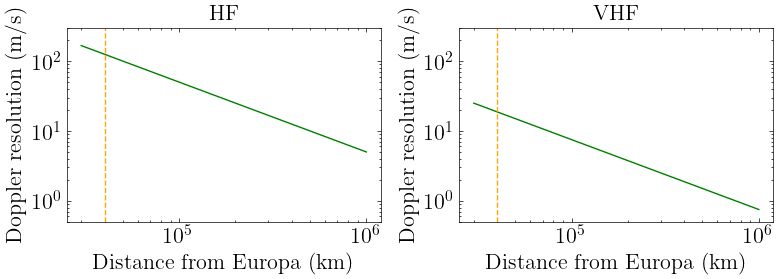

In [98]:
distances = np.linspace(30000*1e3, 1e6*1e3, 100000) 

round_trip_time = 2*distances/c # seconds
frequency_resolution = 1/round_trip_time # Hz
doppler_resolution_hf = frequency_resolution/(9*10**6 / c)
doppler_resolution_vhf = frequency_resolution/(60*10**6 / c)

fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(distances/1000, doppler_resolution_hf, color='green')
ax[0].set_xlabel("Distance from Europa (km)")
ax[0].set_ylabel("Doppler resolution (m/s)")
ax[0].set_title("HF")

ax[1].plot(distances/1000, doppler_resolution_vhf, color='green')
ax[1].set_xlabel("Distance from Europa (km)")
ax[1].set_ylabel("Doppler resolution (m/s)")
ax[1].set_title("VHF")

# Label nadir height
ax[0].axvline(40000, ls='--', color='orange')
ax[1].axvline(40000, ls='--', color='orange')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_ylim((0.5, 300))
ax[1].set_ylim((0.5, 300))
plt.tight_layout()

### SNR-Based Phase Noise
The SNR itself (after pulse compression and/or before) will produce an error in the phase, which results in errors for the frequency estimate in Doppler shift. For a coherent pulse train, we describe this with the lower Cramer-Rao bound for Doppler shift:
$$CRB_{f_d} = \frac{1}{2 \times T \times K \times SNR \times F_s \times R_2} $$

- T = pulse on-time
- K = number of pulses
- $SNR \times F_s$ = SNR times sampling rate
- $R_2$ = variance of pulse times

In [99]:
def cramer_rao_doppler(T, K, SNR, F_s, R_2):
    return 1/(2*T*K*SNR*F_s*R_2)

In [100]:
'''
# Define parameters
T = round_trip_time
K = 
SNR = 10*np.log10(10) # = 10 dB
F_s = 
R_2 = 

cramer_rao_doppler = cramer_rao_doppler(round_trip_time, 10*np.log10(10)) #SNR = 10 dB
print("Cramer Rao lower bound: {:e} Hz".format(cramer_rao_doppler))
'''

'\n# Define parameters\nT = round_trip_time\nK = \nSNR = 10*np.log10(10) # = 10 dB\nF_s = \nR_2 = \n\ncramer_rao_doppler = cramer_rao_doppler(round_trip_time, 10*np.log10(10)) #SNR = 10 dB\nprint("Cramer Rao lower bound: {:e} Hz".format(cramer_rao_doppler))\n'

## Coherent Pulse Train - Doppler Resolution
We can also calculate range ambiguity given the pulse train properties for HF + VHF. 

HF waveform properties:
- $t_{burst}$ = round trip time = $0.267 s$
- T = 1/PRF = $3.3 \times 10^{-7}$ s
- $t_{pulse} = 200 \mu s$

VHF waveform properties:
- $t_{burst}$ = round trip time = $0.267 s$
- T = 1/PRF = $3.3 \times 10^{-7}$ s
- $t_{pulse} = 236 \mu s$

From this, we can calculate the spectral line width $\delta f$, the line spacing $\Delta f$, the ambiguity in frequency measurement, and the ambiguity in range measurement.
$$\delta f \approx t_{burst}^{-1}$$
$$\Delta f \approx T^{-1} = PRF$$
$$f_{amb} = \Delta f$$
$$R_{amb} = c / 2T$$

In [101]:
# Spectral line width
spectral_line_width = 1/0.267 # same for HF, VHF

# Line spacing
line_spacing = 1/3.3e-7 # same for HF, VHF

# Ambiguity in frequency
f_amb = line_spacing

# Ambiguity in range
r_amb = c/(2*3.3e-7)
print("Range resolution: {:e} km".format(r_amb/1000))

Range resolution: 4.542424e+11 km


## Multiple Pulses - Ranging
We can take as many long pulses as possible (maximizing pulse length, PRF), limited by the round trip time of the pulses. We can then compress pulses + pre-sum to obtain an FFT to assess frequency and velocity resolution.

HF signal with following properties:
- Pulse length = $200 \mu s$
- Bandwidth = 1 MHz
- Pulse repetition frequency = 3 kHz
- Carrier (center) frequency = 9 MHz
- Sample rate = 240 Hz (for Doppler frequency)

VHF signal with following properties:
- Pulse length = $236 \mu s$
- Bandwidth = 10 MHz
- Pulse repetition frequency = 3kHz
- Carrier (center) frequency = 60 MHz
- Sample rate = 1600 Hz (for Doppler frequency)

The repetition frequency is limited by the pulse length -- here we can maximize pulse length to get a repetition frequency of 5000 Hz.

In [102]:
import scipy 
import matplotlib.ticker as mticker

d = 400000 # 1 mil km # distance set

# Set parameters
hf_pulse_length = 200e-6 # s
hf_repetition_freq = 3000 # Hz
hf_bandwidth = 1e6 # Hz
hf_chirp_rate = hf_bandwidth/hf_pulse_length # Hz/s
hf_fc = 9e6 # Hz

vhf_pulse_length = 236e-6 # s
vhf_repetition_freq = 3000 # Hz
vhf_bandwidth = 10e6 # Hz
vhf_chirp_rate = vhf_bandwidth/vhf_pulse_length # Hz/s
vhf_fc = 60e6 # Hz

# Set time array, N chirps, sample rate
round_trip_time = 2*d*1e3/c # seconds
print("Round trip time: " + str(round_trip_time) + " s")
N_chirps = int(round_trip_time * hf_repetition_freq) # round
#N_chirps = 10 # TEMPORARY
print("N: " + str(N_chirps))
#print("Time array length: " + str(len(times)))

Round trip time: 2.66844563042028 s
N: 8005


In [103]:
# define chirp signal for HF and VHF
def hf_chirp(N_chirps):
    # FOR ONE CHIRP
    sample_rate = 1/((hf_fc+hf_bandwidth/2) * 10) #s
    #print("Sample rate: {:e} s".format(sample_rate))
    t_onechirp = np.arange(0, hf_pulse_length+sample_rate, sample_rate)
    
    # produce chirp signal
    start = hf_fc + hf_bandwidth/2
    end = hf_fc - hf_bandwidth/2
    chirp_signal = scipy.signal.chirp(t_onechirp, f0=start, f1=end, t1=hf_pulse_length, method='linear')
    
    times = np.arange(0, (N_chirps*(1/hf_repetition_freq)) + sample_rate, sample_rate) 
    # all the times for multiple pulses
    
    res = np.zeros_like(times) # stores final signal
    for i in range(N_chirps):
        # calculate start + end of each pulse
        start_time = i * (1/hf_repetition_freq)
        end_time = start_time + hf_pulse_length
        
        # need to space with sample rate
        start_idx = int(start_time / sample_rate)
        end_idx = int(end_time / sample_rate)
        
        # Ensure we don't exceed time array
        end_idx = min(end_idx, len(res))
        chunk_length = end_idx - start_idx
        
        res[start_idx:end_idx] = chirp_signal[:chunk_length]
    
    return times, res 

def vhf_chirp(N_chirps):
    # FOR ONE CHIRP
    sample_rate = 1/((vhf_fc+vhf_bandwidth/2) * 10) #s
    #print("Sample rate: {:e} s".format(sample_rate))
    t_onechirp = np.arange(0, vhf_pulse_length+sample_rate, sample_rate)
    
    # produce chirp signal
    start = vhf_fc + vhf_bandwidth/2
    end = vhf_fc - vhf_bandwidth/2
    chirp_signal = scipy.signal.chirp(t_onechirp, f0=start, f1=end, t1=vhf_pulse_length, method='linear')
    
    times = np.arange(0, (N_chirps*(1/vhf_repetition_freq)) + sample_rate, sample_rate) # all the times for multiple pulses
    
    res = np.zeros_like(times) # stores final signal
    for i in range(N_chirps):
        # calculate start + end of each pulse
        start_time = i * (1/hf_repetition_freq)
        end_time = start_time + hf_pulse_length
        
        # need to space with sample rate
        start_idx = int(start_time / sample_rate)
        end_idx = int(end_time / sample_rate)
        
        # Ensure we don't exceed time array
        end_idx = min(end_idx, len(res))
        chunk_length = end_idx - start_idx
        
        res[start_idx:end_idx] = chirp_signal[:chunk_length]
    
    return times, res 

Now plotting the signal to visualize how it would look like under the sample rate + within round trip time (assume 40,000 km).

For ranging, we have:
$$CRB_{range} = \frac{c^2}{8 \pi^2 \beta^2 \rm{SNR}}$$

for c = speed of light, $\beta$ = bandwidth.

In [104]:
# TRANSMITTED SIGNAL + NOISE
hf_times, hf_transmit = hf_chirp(N_chirps)
vhf_times, vhf_transmit = vhf_chirp(N_chirps)

# CALCULATING NOISE WITH CRAMER RAO BOUNDS (doubt this is correct)
#crb_hf = (c**2)/(8*np.pi**2*hf_bandwidth**2*10) # used plimit here
#crb_vhf = (c**2)/(8*np.pi**2*vhf_bandwidth**2*10)

hf_withnoise = hf_transmit + np.random.normal(loc=N_galactic, size=len(hf_times))# White Gaussian noise
vhf_withnoise = vhf_transmit + np.random.normal(loc=N_galactic, size=len(vhf_times))

KeyboardInterrupt: 

Below, I follow the tutorial here: https://users.camk.edu.pl/bejger/snr-periodic-signal/

**1. Plotting original signal + noise**

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(hf_times, hf_withnoise, '-', color="grey", label='With noise')
ax[0].plot(hf_times, hf_transmit, '-', color="maroon", label='Without noise', linewidth=2)
ax[1].plot(vhf_times, vhf_withnoise, '-', color="grey")
ax[1].plot(vhf_times, vhf_transmit, '-', color="maroon", linewidth=2)
ax[0].set_title("HF")
ax[1].set_title("VHF")

ax[0].legend()

for axes in ax.reshape(-1):
    axes.set_xlabel("Time (s)", fontsize=10)
    axes.set_ylabel('data = signal + noise')
    axes.grid(True)
    #axes.set_xlim((0, 2e-4))
    axes.locator_params(axis='x', nbins=5)
    axes.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2e'))
    
plt.figure()

**2. Recover signal with matched filter using FFT** 

In [ ]:
# Create the matched filter
hf_matchedfilter = hf_transmit
vhf_matchedfilter = vhf_transmit

# Calculate matched filter == fft(signal)*fft(filter) conjugate
# CONVERT BACK TO TIME SPECTRUM
hf_corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(hf_withnoise)*np.conj(np.fft.fft(hf_matchedfilter))))
vhf_corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(vhf_withnoise)*np.conj(np.fft.fft(vhf_matchedfilter))))

#vhf_corr = scipy.signal.convolve(vhf_withnoise, vhf_matchedfilter, mode='same')

In [ ]:
#### PLOT transmitted + matched filter + received signal (With noise) + cross corr signal####
fig, ax = plt.subplots(4, 2, figsize=(10,8))
ax[0, 0].plot(hf_times, hf_transmit, color='maroon')
ax[1, 0].plot(hf_times, np.conj(hf_matchedfilter), color='maroon') # for plotting
ax[2, 0].plot(hf_times, hf_withnoise, color='grey')
ax[3, 0].plot(hf_times, np.abs(hf_corr), color='navy')

ax[0, 1].plot(vhf_times, vhf_transmit, color='maroon')
ax[1, 1].plot(vhf_times, np.conj(vhf_matchedfilter), color='maroon')
ax[2, 1].plot(vhf_times, vhf_withnoise, color='grey')
ax[3, 1].plot(vhf_times, np.abs(vhf_corr), color='navy')

ax[0,0].set_title("HF")
ax[0,1].set_title("VHF")
ax[0,0].set_ylabel("Transmitted signal")
ax[1,0].set_ylabel("Matched filter")
ax[2,0].set_ylabel("Received signal")
ax[3,0].set_ylabel("Cross correlated signal")

for axes in ax.reshape(-1):
    axes.set_xlabel("Time (s)", fontsize=10)
    axes.grid(True)
    axes.locator_params(axis='x', nbins=5)
    axes.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2e'))
    
#ax[3,0].set_xlim(110e-6, 140e-6)    
#ax[3,1].set_xlim(120e-6, 130e-6) 

**3. Determine the SNR after the matched filter has been applied** 

In [ ]:
#### PLOT signal after matched filter (FFT) ####
fig, ax = plt.subplots(1, 2, figsize=(10,4))
hf_freq = np.fft.fftfreq(len(hf_times), d=hf_times[1]-hf_times[0])
vhf_freq = np.fft.fftfreq(len(vhf_times), d=vhf_times[1]-vhf_times[0])

ax[0].scatter(hf_freq, 10*np.log10(np.abs(np.fft.fft(hf_withnoise))), c="grey", s=5, label='Received signal')
ax[0].scatter(hf_freq, 10*np.log10(np.abs(np.fft.fft(hf_corr))), c='navy', alpha=0.7, s=5, label='Pulse compressed signal')
ax[1].scatter(vhf_freq, 10*np.log10(np.abs(np.fft.fft(vhf_withnoise))), c="grey", s=5, label='Received signal')
ax[1].scatter(vhf_freq, 10*np.log10(np.abs(np.fft.fft(vhf_corr))), c='navy', alpha=0.7, s=5, label='Pulse compressed signal')
ax[0].set_title("HF")
ax[1].set_title("VHF")

for axes in ax.reshape(-1):
    #axes.set_xlim(np.min(sample_freq), np.max(sample_freq)) 
    # can take positive spectrum only: plt.xlim(0, np.max(sample_freq)) 
    axes.set_xlabel("Frequency bins", fontsize=10)
    axes.set_ylabel('Fourier transform power (dB)', fontsize=10)
    axes.grid(True)
ax[0].set_xlim(0.5e7, 1.3e7)
ax[1].set_xlim(0.3e8, 0.9e8)

#ax[0].legend(loc='best', fontsize=8)

SNR = height of peak / variance of noise floor

In [ ]:
# Finds SNR after matched filter is applied
# input of signal with noise, signal after cross corr. (NOT FFT)
def SNR_mf(signal_withnoise, signal_corr, Pt, Gt, d, rcs, wavelength):
    # find noise floor of returned signal + peak of correlated signal
    noise_floor_variance = np.median(signal_withnoise) # centered on this
    
    SNR_mf = np.max(signal_corr)/noise_floor_variance
    
    # find the Pr/Pt scale from the radar equation
    Pr = radar_equation(Pt, Gt, d, rcs, wavelength)
    
    SNR_mf *= (Pr/Pt)
    
    return 10*np.log10(SNR_mf)

dlimit = 100000e3 

print("#### UNSCALED with distance ####")
SNR_mf_unscaled_hf = np.max(np.abs(np.fft.fft(hf_corr)))/np.median(np.abs(np.fft.fft(hf_withnoise)))
SNR_mf_unscaled_vhf = np.max(np.abs(np.fft.fft(vhf_corr)))/np.median(np.abs(np.fft.fft(vhf_withnoise)))

print("HF SNR: {:.2f} dB".format(10*np.log10(SNR_mf_unscaled_hf)))
print("VHF SNR: {:.2f} dB".format(10*np.log10(SNR_mf_unscaled_vhf)))

print("#### SCALED with distance ####")
print("HF SNR: {:.2f} dB".format(SNR_mf(np.abs(np.fft.fft(hf_withnoise)), np.abs(np.fft.fft(hf_corr)), Pt_hf, Gt_hf, dlimit, rcs_hf, hf_wavelength)))
print("VHF SNR: {:.2f} dB".format(SNR_mf(np.abs(np.fft.fft(vhf_withnoise)), np.abs(np.fft.fft(vhf_corr)), Pt_vhf, Gt_vhf, dlimit, rcs_vhf, vhf_wavelength)))

### Find gain from 1 pulse vs. pulses filling up round trip time
To test how much the signal improves... (10/20/24)

In [105]:
one_pulse = radar_equation(Pt_hf, Gt_hf, 400000000, rcs_hf, hf_wavelength) # d = 1 mil km
N_power = 3.52e-9 # W from before (converted from W/MHz/m^2)

print("One pulse dB: {:.2f}".format(10*np.log10(one_pulse/N_power)))
print("Pulse compression gain estimated dB: {:.2f}".format(pulse_compression_gain_hf))

One pulse dB: -139.38
Pulse compression gain estimated dB: 23.73


#### Plot number of pulses vs. maximum range
Solve for the maximum range with each N_chirps pulse train.
We can use the radar equation to solve for the minimum 10 dB limit for detection:
$$\frac{\rm{Matched, unscaled SNR [B]}}{10 [B]} = \frac{G_t \sigma A_e}{16 \pi d^4 \times N_{galactic}}$$

were we can describe $P_r$ with the radar equation, giving us the following expression for range:

$$ d = \left[\rm{Matched, unscaled SNR} \times \frac{G_t \sigma A_e}{P_{limit} \times N_{galactic} \times 16 \pi^2}\right]^{\frac{1}{4}} $$


In [106]:
'''
INPUT: minimum range
OUTPUT: number of pulses needed

dlimit = minimum range that Clipper is at (e.g. 100,000 km) (in m)

We need SNR (Pr/N) of 10 dB @ 100,000 km
'''
# Plimit, SNR_mf in dB!!!
def range_pt(Plimit, SNR_mf, Gt, rcs, wavelength):
    Ae = (Gt*wavelength**2)/(4*np.pi)
    d = ((SNR_mf * Gt * rcs * Ae)/(10*N_galactic*16*np.pi**2))**0.25
    return d

HF_pulsetrain_max_range = range_pt(10, 10*np.log10(SNR_mf_unscaled_hf), Gt_hf, rcs_hf, hf_wavelength)
HF_pulsetrain_max_range = range_pt(10, SNR_mf_unscaled_hf, Gt_hf, rcs_hf, hf_wavelength)
print(HF_pulsetrain_max_range)

242536011.22303876


In [107]:
N_chirps_array = np.arange(1,101,1)
#N_chirps_array = [200]

HF_pulsetrain_res = np.array([])
VHF_pulsetrain_res = np.array([])
for Niterator in N_chirps_array:
    print(Niterator)
    #### TRANSMITTED SIGNAL
    hf_times, hf_transmit = hf_chirp(Niterator)
    vhf_times, vhf_transmit = vhf_chirp(Niterator)
    
    #### ADD NOISE
    hf_withnoise = hf_transmit + np.random.normal(loc=N_galactic, size=len(hf_times)) # White Gaussian noise
    vhf_withnoise = vhf_transmit + np.random.normal(loc=N_galactic, size=len(vhf_times))

    # Create the matched filter
    hf_matchedfilter = hf_transmit
    vhf_matchedfilter = vhf_transmit

    # Calculate matched filter == fft(signal)*fft(filter) conjugate
    hf_corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(hf_withnoise)*np.conj(np.fft.fft(hf_matchedfilter))))
    vhf_corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(vhf_withnoise)*np.conj(np.fft.fft(vhf_matchedfilter))))

    # create frequencies for FFT
    hf_freq = np.fft.fftfreq(len(hf_times), d=hf_times[1]-hf_times[0])
    vhf_freq = np.fft.fftfreq(len(vhf_times), d=vhf_times[1]-vhf_times[0])

    #### FIND MAX. RANGE FOR EVERY N CHIRPS
    # Find unscaled SNR
    SNR_mf_unscaled_hf = np.max(np.abs(np.fft.fft(hf_corr)))/np.median(np.abs(np.fft.fft(hf_withnoise)))
    SNR_mf_unscaled_vhf = np.max(np.abs(np.fft.fft(vhf_corr)))/np.median(np.abs(np.fft.fft(vhf_withnoise)))
    
    # We can set P_required with the equation above (in dB)
    #print("SNR matched unscaled HF (in db):" + str(10*np.log10(SNR_mf_unscaled_hf)))
    #print("SNR matched unscaled VHF (in db):" + str(10*np.log10(SNR_mf_unscaled_vhf)))
    
    # solve for the maximum range
    HF_pulsetrain_max_range = range_pt(10, SNR_mf_unscaled_hf, Gt_hf, rcs_hf, hf_wavelength)
    #print("Max. range HF: {:e}".format(HF_pulsetrain_max_range))
    HF_pulsetrain_res = np.append(HF_pulsetrain_res, HF_pulsetrain_max_range)
    
    VHF_pulsetrain_max_range = range_pt(10, SNR_mf_unscaled_vhf, Gt_vhf, rcs_vhf, vhf_wavelength)
    #print("Max. range VHF: {:e}".format(VHF_pulsetrain_max_range))
    VHF_pulsetrain_res = np.append(VHF_pulsetrain_res, VHF_pulsetrain_max_range)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


In [ ]:
#### PLOT RESULTS ####
plt.style.use(['science'])
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].scatter(N_chirps_array, HF_pulsetrain_res/1e3, color='black',s=15)
ax[1].scatter(N_chirps_array, VHF_pulsetrain_res/1e3, color='black',s=15)
ax[0].set_title("HF")
ax[1].set_title("VHF")

for axes in ax.reshape(-1):
    axes.set_xlabel('Number of summed pulses')
    axes.set_ylabel('Maximum range (km)')
    axes.grid(True, alpha=0.2)
    axes.locator_params(axis='x', nbins=5)
    axes.locator_params(axis='y', nbins=5)
    axes.axhline(40e3, ls='--', color='maroon', lw=2)
    axes.axhline(100e3, ls='--', color='maroon', lw=2)
    #axes.ticklabel_format(axis='y', style='sci')
    #axes.yaxis.major.formatter.set_powerlimits((0,0))
    
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3,2))
    axes.yaxis.set_major_formatter(formatter)
ax[0].text(67.5, 45e3, "40,000 km", color='maroon', fontsize=16)
ax[1].text(67.5, 43.5e3, "40,000 km", color='maroon', fontsize=16)
ax[0].text(63.5, 105e3, "100,000 km", color='maroon', fontsize=16)
ax[1].text(63.5, 103.5e3, "100,000 km", color='maroon', fontsize=16)

fig.suptitle("Maximum range and coherently summed pulses", fontsize=17, fontweight='bold')
fig.tight_layout()
plt.show()
fig.savefig("figs/max-range-withtitle.pdf")

print("#### 1st pulse ####")
print("HF: " + str(HF_pulsetrain_res[-1]/1e3))
print("VHF: " + str(VHF_pulsetrain_res[-1]/1e3))

print("#### Min for 100,000 km ####")
min_hf = N_chirps_array[np.argmin(np.abs(HF_pulsetrain_res - 40000000))]
min_vhf = N_chirps_array[np.argmin(np.abs(VHF_pulsetrain_res - 40000000))]
print("HF: " + str(min_hf))
print("VHF: " + str(min_vhf))

STOP

## Doppler resolution -- multiple pulses
We can define the sampling rate with Nyquist's theorem to be twice the Doppler resolution in frequency. We can then convert our result to velocity resolution using $\Delta v = \Delta f_d \lambda / 2$, which represents the accuracy in determining the radial velocity of Europa.

In [ ]:
def simple_velocity(range_1, range_2):
    time_dif = 1/3000 # 1/PRF
    return (range_2 - range_1) / time_dif

In [ ]:
HF_pulsetrain_res = np.array([])
VHF_pulsetrain_res = np.array([])

hf_freq = 9e6 #Hz
vhf_freq = 60e6
v = 3700 #m/s for now?

distances = np.linspace(100e3*1e3, 500e3*1e3, 100) #m

#### VHF ####
vhf_vel_res = np.array([])
for d in distances:
    Niterator = round((2*d/c)/vhf_pulse_length) # divide by pulse length
    # for 100,000 km -- 1333 pulses for HF, 1130 pulses for VHF
    print("Pulse count: " + str(Niterator))
    sampling_length = Niterator*vhf_pulse_length # s -- multiply by total observed time

    # doppler freq 
    f_d = 2*vhf_freq*v/c
    print("Doppler frequency: {0:.2f} Hz".format(f_d))

    # check if nyquist is satisfied on doppler freq
    nyquist_satisfied = bool(3000 >= 2*f_d)
    print("Nyquist satisfied (PRF >= 2x Doppler freq.)? -- " + str(nyquist_satisfied))

    # doppler res = 1/total pulse (aka sampling length -- post summing)
    print("Sampling length: {0:.6f} s".format(sampling_length))
    doppler_res = 1/sampling_length # Hz
    print("Doppler resolution (1/total observed time): {0:.2f} Hz".format(doppler_res))

    #v = f*wavelength/2
    v_res = doppler_res*vhf_wavelength/2 #m/s
    print("Velocity measurements: {0:.2f} m/s".format(v_res))
    
    vhf_vel_res = np.append(vhf_vel_res, v_res)
    
#### HF ####
hf_vel_res = np.array([])
for d in distances:
    Niterator = round((2*d/c)/hf_pulse_length) # divide by pulse length
    sampling_length = Niterator*hf_pulse_length # s -- multiply by total observed time
    f_d = 2*hf_freq*v/c
    nyquist_satisfied = bool(3000 >= 2*f_d)
    doppler_res = 1/sampling_length # Hz
    v_res = doppler_res*hf_wavelength/2 #m/s
    hf_vel_res = np.append(hf_vel_res, v_res)

In [ ]:
#### PLOT RESULTS ####
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(distances/1e3, hf_vel_res, color='#4a1029')
ax[1].scatter(distances/1e3, vhf_vel_res, color='#4a1029')
ax[0].set_title("HF", fontsize=12)
ax[1].set_title("VHF", fontsize=12)

for axes in ax.reshape(-1):
    axes.set_xlabel('Altitude (km)', fontsize=12)
    axes.set_ylabel('Velocity resolution (m/s)', fontsize=12)
    axes.grid(True)
    axes.locator_params(axis='x', nbins=7)
    axes.locator_params(axis='y', nbins=7)
    #axes.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2e'))
    #axes.set_ylim((0, 5))

fig.tight_layout()
plt.show()
plt.savefig("maxrange.pdf")